In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [3]:
particle2pdg={11:'eminus',-11:'eminus',13:'muon',-13:'muon',22:'gamma',211:'piminus',-211:'piminus',2212:'proton'}
pdg2instance={'eminus':3,'gamma':4,'muon':6,'piminus':8,'proton':9}

In [4]:
from larcv import larcv

Welcome to ROOTaaS 6.06/06


In [5]:
from MCNN_uboone import ShapesConfig
class ShapesConfig(ShapesConfig):
#     RPN_ANCHOR_RATIOS = [0.25, 0.5,  1,  2, 4]
    RPN_ANCHOR_RATIOS = [0.5,  1,  2]
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64, 128, 256]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        20
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_NUMBER           1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE      

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
def getRGBfromI(RGBint):
#     print RGBint
    RGBint=int(RGBint)
    blue =  RGBint & 255
    green = (RGBint >> 8) & 255
    red =   (RGBint >> 16) & 255
    return red, green, blue

In [8]:
from MCNN_uboone import ShapesDataset

In [9]:
dataset_train = ShapesDataset("/data/dayajun/sw/Mask_RCNN/uboone/training_data/75_200.root")
dataset_train.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# dataset_val = ShapesDataset("/data/dayajun/toymodel/uboone/train_data/75_200_val.root")
# dataset_val.load_shapes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.prepare()

    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: /data/dayajun/sw/Mask_RCNN/uboone/training_data/75_200.root
    [NORMAL]  <IOManager::initialize> Prepared input with 49974 entries...


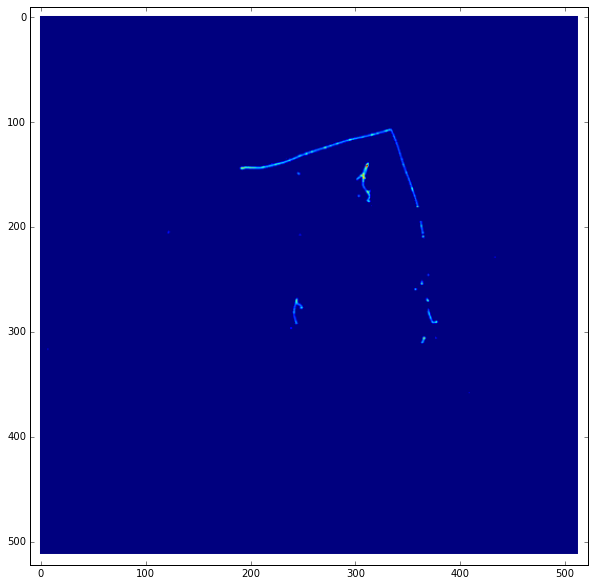

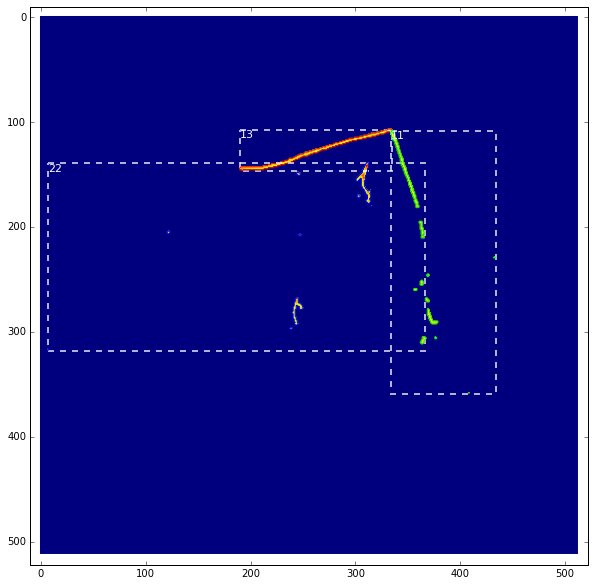

In [10]:
# reload(modellib)
# reload(visualize)
# reload(utils)
#Look at dataset_val
# fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20,10))
fig, ax0 = plt.subplots(1,1,figsize=(10,10))
fig, ax1 = plt.subplots(1,1,figsize=(10,10))

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
inference_config = InferenceConfig()

image_id=14
# print 'image_id ',image_id
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)


# print np.sum(original_image)
    
# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)
# print np.sum(original_image)

#     print '===========Detection==========='
ax0.imshow(original_image[:,:,0])
ax0.set_ylim(512 + 10, -10)
ax0.set_xlim(-10, 512 + 10)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8),ax=ax1)



[6 3 8 8 1]


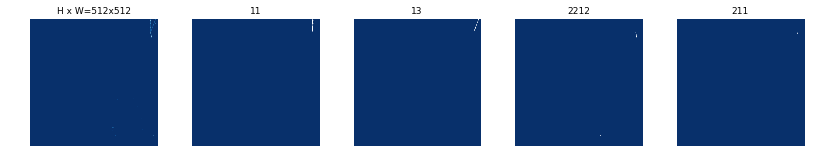

[8 6 1 2]


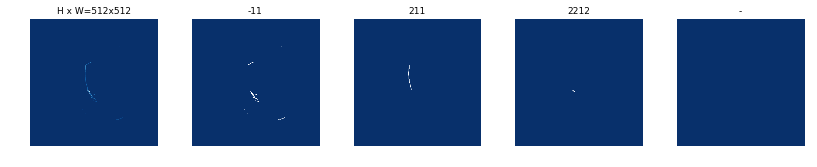

In [11]:
# print dataset_train.image_ids
image_ids = np.random.choice(dataset_train.image_ids, 2)
# image_ids=[0,1]
# print image_ids
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
#     print 'image_id',image_id
#     print image.shape
#     print set(image.flatten())
#     print np.sum(image)
#     print mask.shape
#     for i in xrange(mask.shape[-1]):
#         print np.sum(mask[:,:,i]),
#     print ' '
    print class_ids
    visualize.display_top_masks(image[:,:,0], mask, class_ids, dataset_train.class_names)

In [12]:
print dataset_train._image_ids

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


# Training

In [13]:
# # Create model in training mode
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)


In [14]:
# # Training Heads
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=1, 
#             layers='heads')

In [15]:
# # Training ALl
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

# Detection

In [16]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weight
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()
model_path="/data/dayajun/sw/Mask_RCNN/logs/particles20181001T1620/mask_rcnn_particles_0077.h5"

# Load trained weights
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)

('Loading weights from ', '/data/dayajun/sw/Mask_RCNN/logs/particles20181001T1620/mask_rcnn_particles_0077.h5')
Re-starting from epoch 77


2018-10-02 01:13:31.837352: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-10-02 01:13:31.994524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:04:00.0
totalMemory: 11.92GiB freeMemory: 11.00GiB
2018-10-02 01:13:31.994573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2)


In [20]:
import pydot
import graphviz

In [18]:
# model.keras_model.layers_by_depth

from keras.utils import plot_model
plot_model(model.keras_model)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
# reload(visualize)
# reload(utils)
#Look at dataset_val
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8))

image_id = random.choice(dataset_train.image_ids)
image_id=6
print 'image_id ',image_id
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

# print np.sum(original_image)
    
# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)
# print np.sum(original_image)

#     print '===========Detection==========='

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8),ax=ax0)
print np.sum(original_image)
results = model.detect([original_image], verbose=1)
print np.sum(original_image)

r = results[0]
#     print r['rois'].shape
#     print r['masks'].shape
#     print r['class_ids'].shape
#     print np.sum(original_image)

# print np.sum(r['masks'])

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=ax1)

# visualize.display_differences(original_image,gt_bbox, gt_class_id, gt_mask, r['rois'],\
#                               r['class_ids'],r['scores'],r['masks']\
#                              ,dataset_train.class_names)

In [ ]:
for image_id in xrange(0,50):
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8))

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config, 
                               image_id, use_mini_mask=False)

#     log("original_image", original_image)
#     log("image_meta", image_meta)
#     log("gt_class_id", gt_class_id)
#     log("gt_bbox", gt_bbox)
#     log("gt_mask", gt_mask)
#     print np.sum(original_image)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, figsize=(8, 8),ax=ax0)

    results = model.detect([original_image], verbose=0)
    r = results[0]
            
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], ax=ax1)


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5# Comput 
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
test=np.array([[1,2,3],[1,2,3]])
cover=np.array([[1,1,1],[1,1,0]])
print test.shape
print cover.shape

shit=test*cover
print shit.shape

In [ ]:
print shit

In [ ]:
np.zeros((2,1,0))